# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.575862,True,7.040007
1,1.522446,True,6.578798
2,1.858096,True,4.823697
3,0.577649,True,4.883111
4,-0.555057,False,-1.287437
...,...,...,...
995,-0.707002,False,-0.489885
996,0.326141,True,3.266617
997,1.649525,True,5.137859
998,1.840091,True,5.889908


<AxesSubplot:xlabel='v0'>

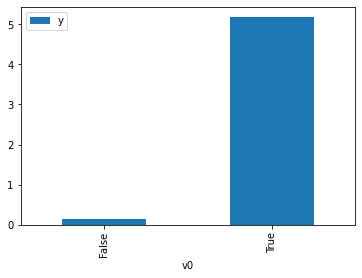

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

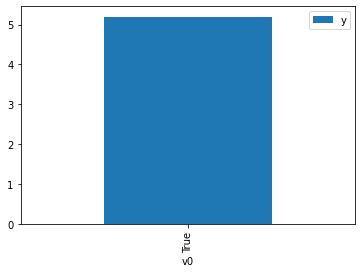

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.450583,False,-0.153651,0.022874,43.718663
1,0.528632,False,-0.226960,0.186974,5.348337
2,-0.562946,False,1.343504,0.774768,1.290710
3,-2.304997,False,0.706976,0.996138,1.003877
4,1.129072,False,0.374258,0.049367,20.256437
...,...,...,...,...,...
995,-1.109958,False,0.687540,0.930285,1.074940
996,1.345510,False,1.223789,0.029477,33.925148
997,1.448495,False,2.145191,0.022989,43.498181
998,0.723429,False,0.418983,0.124275,8.046658


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.537472,True,7.025476,0.981476,1.018874
1,0.997136,True,6.697967,0.932822,1.072016
2,-0.995357,True,5.787307,0.090540,11.044854
3,0.457138,True,4.339850,0.784589,1.274553
4,-0.461938,True,5.393236,0.271880,3.678093
...,...,...,...,...,...
995,0.124249,True,4.539032,0.614821,1.626490
996,0.073698,True,5.263751,0.584760,1.710103
997,-0.222467,True,4.312133,0.403324,2.479393
998,-1.070775,True,6.454683,0.076282,13.109240


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                          1.008e+04
Date:                Wed, 20 Jul 2022   Prob (F-statistic):                        0.00
Time:                        18:05:44   Log-Likelihood:                         -1384.1
No. Observations:                1000   AIC:                                      2772.
Df Residuals:                     998   BIC:                                      2782.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2289      0.038      6.034      0.000       0.154       0.303
x2             5.0064      0.052     97.181      0.000       4.905       5.107
==============================================================================
Omnibus:                        2.274   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.321   Jarque-Bera (JB):                2.173
Skew:                          -0.111   Prob(JB):                        0.337
Kurtosis:                       3.050   Cond. No.                         2.54
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""